In [1]:
from sqlalchemy import create_engine
from operator import itemgetter
import json
import math
import time

import pandas as pd
import numpy as np
#import seaborn as sns
from sklearn import linear_model
from skopt import gp_minimize
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision=3, suppress=True)
pd.options.mode.chained_assignment = None

In [523]:
race_type = 'R'
# race_type = 'G'
# race_type = 'H'

bet_type = 'W'
# bet_type = 'P'

pred = '{}_pred'.format(bet_type)
prob = '{}_prob'.format(bet_type)
bet = '{}_bet'.format(bet_type)

In [505]:
engine = create_engine('sqlite:///../../data/race.db')
conn = engine.connect()

dfoo = pd.read_sql_table('race', conn)
dfoo = dfoo.sort_values('race_start_time')
dfoo = dfoo[int(len(dfoo) * 0.15):]
print('{} races loaded!'.format(len(dfoo)))

59534 races loaded!


In [524]:
dfo = dfoo.loc[dfoo['race_type'].isin([race_type])]
print('{} {} races for {} betting!'.format(len(dfo), race_type, bet_type))

19588 R races for W betting!


In [525]:
dfo['results'] = dfo['results_data'].map(json.loads)
dfo['runners'] = dfo['runners_data'].map(json.loads)
print('results and runners decoded')

results and runners decoded


In [526]:
# bet size
balance = 1000
bet_chunk = balance * 0.01

In [527]:
def process_strategy(dfp, strategy, x):
    """run strategy, must pass runners returned back into results (it might be modified)"""
    book = []
    for _, race in dfp.iterrows():
#         print(race['num_runners'])
        runners = race['runners']
        
        # drop scratched
        runners = [r for r in runners if r['has_odds']]
        if not runners:
            continue

        try:
            runners, num_bets = strategy(runners, bet_chunk, race_type, bet_type, x)
        except Exception as e:
            print(runners)
            raise
            
        if num_bets:
            bet_results(book, runners, bet_chunk, num_bets)
            
    book_df = pd.DataFrame(book)
    return book_df

In [528]:
def bet_results(book, runners, bet_chunk, num_bets):
    """get results from bets"""
    place_cutoff = 3 if len(runners) >= 8 else 2

    win_diff = 0
    max_diff = 0
    odds_scales = []
    rating_scales = []
    # profit start with loss of bet made
    outcome = {
        'success': 0,
        'profit': -bet_chunk,
        'num_bets': num_bets,
        'num_runners': len(runners),
    }
    for i, runner in enumerate(runners):
        diff = abs(runner['fws'] - runner[prob])
        max_diff = max(max_diff, diff)
        if int(runner['finishingPosition']) == 1:
            win_diff = diff

        if runner[bet]:
            odds_scales.append(runner['odds_scaled'])

            if bet_type == 'W':
                if int(runner['finishingPosition']) == 1:
                    outcome['success'] = 1
                    # profit will be payout added against inital deduction
                    # winnings is the bet made times the odds
                    winnings = runner[bet] * runner['win_odds']
                    outcome['profit'] += winnings
                break
            elif bet_type == 'P':
                if 1 <= int(runner['finishingPosition']) <= place_cutoff:
                    # success is how correct each placement was
                    outcome['success'] += 1 / num_bets
                    # profit will be return added and offset against inital deduction
                    # winnings is the bet made times the odds
                    winnings = runner[bet] * runner['place_odds']
                    outcome['profit'] += winnings

    outcome['max_diff'] = max_diff
    outcome['win_diff'] = win_diff
    outcome['odds_scales'] = min(odds_scales)
    outcome['bet_chunk'] = bet_chunk

    book.append(outcome)

In [529]:
def bet_positive_dutch(runners, bet_chunk, race_type, bet_type, x=None):
    """dutch betting on probability"""
    scaled = '{}_scaled'.format(bet_type)
    prob = '{}_prob'.format(bet_type)
    bet = '{}_bet'.format(bet_type)

    if bet_type == 'W':
        key_odds = 'win_odds'
        key_scaled = 'fws'
    else:
        key_odds = 'place_odds'
        key_scaled = 'fps'

    # sort runners from favourite to underdog
    runners.sort(key=lambda r: r.get(prob, 0), reverse=True)
    
    # start betting on all and cut off worse runner till positive outcome
    for num_bets in range(len(runners), -1, -1):

        # reset bets
        for runner in runners:
            runner[bet] = 0

        # recreate smaller pool
        pool = runners[:num_bets]
        assert len(pool) == num_bets
        if not pool:
            continue

        # all prediction values
        total_probs = sum([r[prob] for r in pool])
        if not total_probs:
            continue

        # dutch for all in pool
        for runner in pool:

            # scale bet according to prediction
            runner[bet] = round(bet_chunk * runner[prob] / total_probs, 1)
            runner['{}_type'.format(bet)] = 'parimutuel'
#             print('bet {:.2f}'.format(runner[bet]))

            # need to check all as we scale to probs and not odds
            odds = runner[key_odds]
            odds_scaled = runner[key_scaled]
            runner['payout'] = runner[bet] * odds
            runner['odds_scaled'] = runner[prob] / odds_scaled

        total_bets = sum(p[bet] for p in pool)
        profits = [p['payout'] - total_bets for p in pool]
        odds_scaled = [r['odds_scaled'] for r in runners]

        ###################################################################################
        # FIRST
        ###################################################################################
        first_profit_flag = False
        if profits[0] / bet_chunk >= x[0]:
            first_profit_flag = True

        ###################################################################################
        # AVG 
        ###################################################################################
        avg_profit_flag = False
        avg_profit = sum(profits) / len(profits)
        if avg_profit / bet_chunk >= x[1]:
            avg_profit_flag = True
        
        ###################################################################################
        # LAST
        ###################################################################################
        last_profit_flag = False
        if profits[-1] / bet_chunk >= x[2]:
            last_profit_flag = True
        
        if sum([last_profit_flag, avg_profit_flag, first_profit_flag]) >= 2:
#             print('breaking!')
            break
    else:
        assert all(r[bet] == 0 for r in runners)
        assert num_bets == 0
        return runners, num_bets

    # put bets from pool into runners
    for p in pool:
        for r in runners:
            if r['runnerNumber'] == p['runnerNumber']:
                r[bet] = p[bet]
                r['{}_type'.format(bet)] = p['{}_type'.format(bet)]
                break

    return runners, num_bets

In [530]:
def f(x):
    print('.', end='')
    df_sample = dfo.sample(frac=0.5)
#     print('sample size of {}/{}'.format(len(df_sample), len(dfo)))
    book_df = process_strategy(df_sample, bet_positive_dutch, x)
#     print(book_df)
    if not len(book_df):
        return 0
    profit = book_df.profit.sum()
    return profit / len(dfo) * -1


print('optimizing', end='')
time_start = time.time()
x_slice = np.s_[0:8:10j, 0:8:10j, 0:8:10j]
x, *grid = sp.optimize.brute(f, ranges=x_slice, full_output=True)

# SKopt
# res = gp_minimize(f, [(0., 5.), (0., 5.)], n_calls=200, n_jobs=8)
# print(res)

print('done: took {:.0f}s'.format((time.time() - time_start)), flush=True)
# print('x: {}'.format(x))
# print('grid: {}'.format(grid))

optimizing..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [531]:
print('race type: {}'.format(race_type))
print('bet type: {}'.format(bet_type))
print('x: {}'.format(x))
df = process_strategy(dfo, bet_positive_dutch, x)
print('${:.2f} profit per race'.format(df.profit.sum() / len(dfo)))
print('{:.0f}% of races {} / {}'.format(len(df) / len(dfo) * 100, len(df), len(dfo)))

race type: R
bet type: W
x: [ 2.658  3.581  6.256]
$0.08 profit per race
11% of races 2204 / 19588


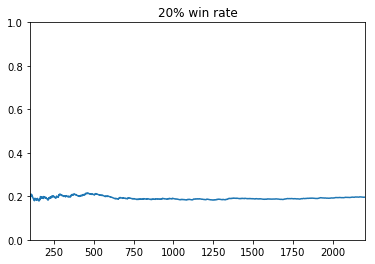

In [532]:
df['ones'] = np.ones(len(df))
df['win_rate'] = df.success.cumsum() / df.ones.cumsum()
win_title = '{:.0f}% win rate'.format(df.win_rate.iloc[-1] * 100)
df.win_rate.plot(title=win_title, xlim=(100), ylim=(0, 1))

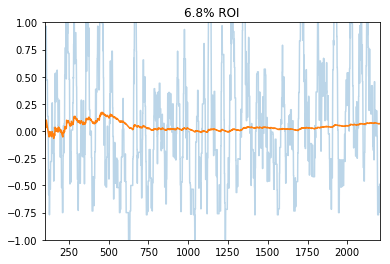

In [533]:
# ROI
roi = df.profit.rolling(20).sum() / df.bet_chunk.rolling(20).sum()
roi.plot(xlim=(100), ylim=(-1, 1), alpha=0.3)
roi = df.profit.cumsum() / df.bet_chunk.cumsum()
roi_title = '{:.1f}% ROI'.format(roi.iloc[-1] * 100)
roi.plot(xlim=(100), ylim=(-1, 1), title=roi_title)

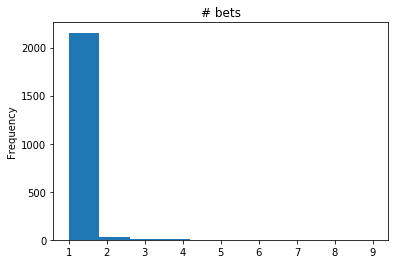

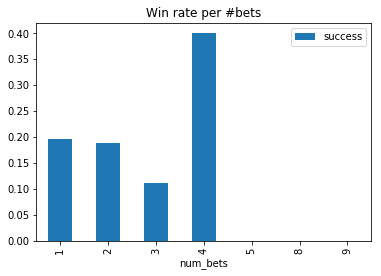

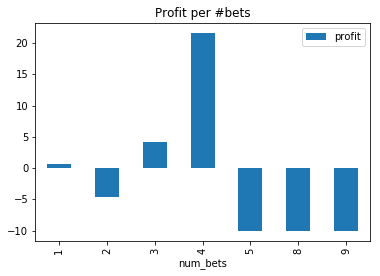

In [534]:
# profit per num bets 
df.num_bets.plot(kind='hist', title='# bets')
groups = df.groupby('num_bets').mean()
groups.plot(kind='bar', y='success', title='Win rate per #bets')
groups.plot(kind='bar', y='profit', title='Profit per #bets')

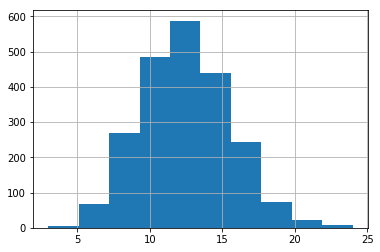

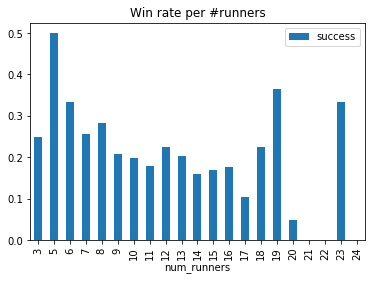

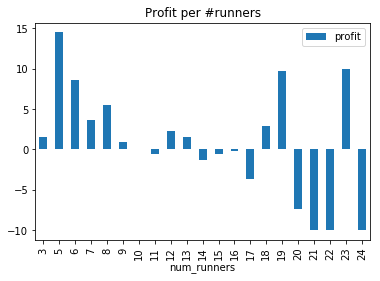

In [535]:
# profit per num runners
df.num_runners.hist()
groups = df.groupby('num_runners').mean()
groups.plot(kind='bar', y='success', title='Win rate per #runners')
groups.plot(kind='bar', y='profit', title='Profit per #runners')

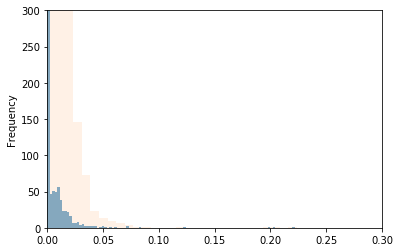

In [536]:
# max diff
df.win_diff.plot(kind='hist', bins=100, alpha=0.6, ylim=(0, 300), xlim=(0, 0.3))
df.max_diff.plot(kind='hist', bins=100, alpha=0.1, ylim=(0, 300), xlim=(0, 0.3))

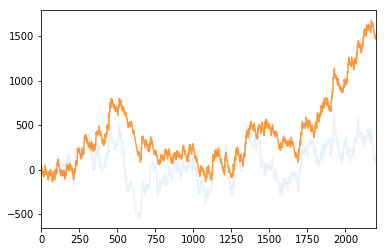

In [537]:
# df.profit.plot(kind='hist', bins=50, xlim=(-5), ylim=(0, 140))
df.profit.rolling(100).sum().plot(alpha=0.1)
df.profit.cumsum().plot(alpha=0.8)

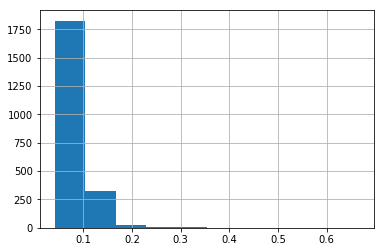

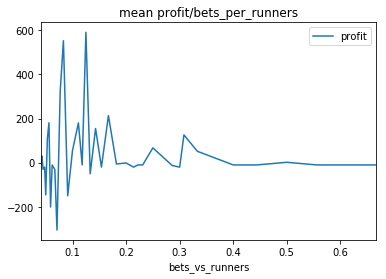

In [538]:
# bets/runners
df['bets_vs_runners'] = df.num_bets / df.num_runners
df['bets_vs_runners'].hist(bins=10)
groups = df.groupby(df['bets_vs_runners'].apply(lambda x: round(x, 3))).sum()
groups.plot(kind='line', y='profit', title='mean profit/bets_per_runners')

In [539]:
# # pred vs scale
# df['prob_vs_scale'] = df.pr / df.num_runners
# df['bets_vs_runners'].hist(bins=10)
# groups = df.groupby(df['bets_vs_runners'].apply(lambda x: round(x, 3))).sum()
# groups.plot(kind='line', y='profit', title='mean profit/bets_per_runners')

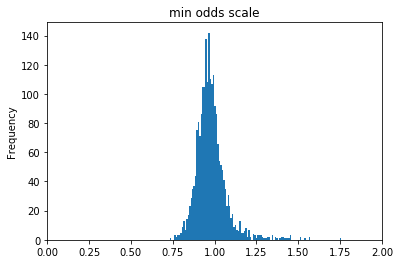

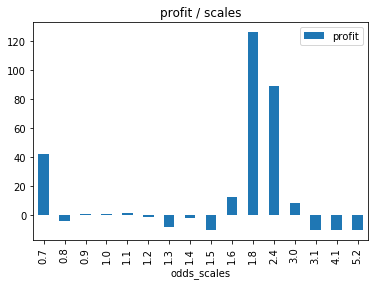

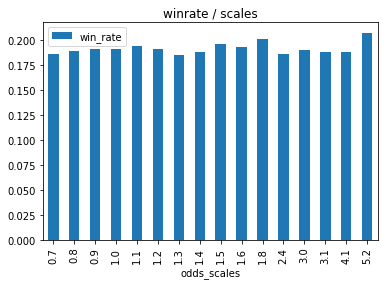

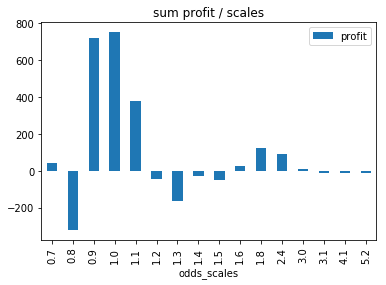

In [540]:
df.odds_scales.plot(kind='hist', bins=500, title='min odds scale', xlim=(0, 2))
groups = df.groupby(df['odds_scales'].apply(lambda x: round(x, 1))).mean()
groups.plot(kind='bar', y='profit', title='profit / scales')
groups.plot(kind='bar', y='win_rate', title='winrate / scales')

groups_sum = df.groupby(df['odds_scales'].apply(lambda x: round(x, 1))).sum()
groups_sum.plot(kind='bar', y='profit', title='sum profit / scales')